### 코드 순서
- [0️⃣ Initialize notebook variables](#0)
- [🧪 직접 HTTP를 호출하여 API 테스트](#requests)
- [🔍 Token rate limiting 결과 분석](#plot)

### 사전 준비 사항
- [Python 3.8 or later version](https://www.python.org/) installed
- [Pandas Library](https://pandas.pydata.org/) and matplotlib installed
- [VS Code](https://code.visualstudio.com/) installed with the [Jupyter notebook extension](https://marketplace.visualstudio.com/items?itemName=ms-toolsai.jupyter) enabled
- [Azure CLI](https://learn.microsoft.com/en-us/cli/azure/install-azure-cli) installed
- [Sign in to Azure with Azure CLI](https://learn.microsoft.com/en-us/cli/azure/authenticate-azure-cli-interactively)

<a id='0'></a>
### 0️⃣ Initialize notebook variables

- 리소스 그룹 명, Azure OpenAI에서 배포한 deployment 이름 (예: gpt-4o), OpenAI API 버전 (예:2024-02-01)을 입력합니다.
- API Gateway URL과 Subscription Key를 입력합니다.
- Subscription Key는 Azure Portal의 API Management 리소스에서 APIs->Subscriptions->Built-in all-access subscription의 Primary key를 입력합니다.

In [ ]:
import os
import json
import datetime
import requests

resource_group_name = "{your_resource_group_name}" # 이전 단계에서 생성한 리소스 그룹 이름을 입력합니다.
openai_deployment_name = "gpt-4o"
openai_api_version = "2024-02-01"
openai_model_name = "gpt-4o"
apim_resource_gateway_url = "{your_apim_resource_gateway_url}" # 이전 단계에서 생성한 APIM 리소스의 게이트웨이 URL을 입력합니다.
apim_subscription_key = "{your_apim_subscription_key}" # 이전 단계에서 생성한 APIM 리소스의 구독 키를 입력합니다.


<a id='requests'></a>
### 🧪 Test the API using a direct HTTP call

Tip: Use the [tracing tool](../../tools/tracing.ipynb) to track the behavior and troubleshoot the [policy](policy.xml).

In [6]:
url = apim_resource_gateway_url + "/openai/deployments/" + openai_deployment_name + "/chat/completions?api-version=" + openai_api_version
api_runs = []
for i in range(5):
    messages={"messages":[
        {"role": "system", "content": "You are a sarcastic unhelpful assistant."},
        {"role": "user", "content": "Can you tell me the time, please?"}
    ]}
    response = requests.post(url, headers = {'Ocp-Apim-Subscription-Key':apim_subscription_key}, json = messages)
    
    if (response.status_code == 200):
        print("▶️ Run: ", i+1, "status code: ", response.status_code, "✅")
        data = json.loads(response.text)
        total_tokens = data.get("usage").get("total_tokens")
        print("💬 ", data.get("choices")[0].get("message").get("content"))
    else:
        print("▶️ Run: ", i+1, "status code: ", response.status_code, "⛔")
        print(response.text)
        total_tokens = 0
    api_runs.append((total_tokens, response.status_code))


▶️ Run:  1 status code:  200 ✅
💬  Oh, of course! Let me just peer into my magical crystal ball... Oh wait, I can't actually tell the time. You might want to try checking a clock or a phone. Those tend to be pretty reliable!
▶️ Run:  2 status code:  200 ✅
💬  Oh, absolutely! Just let me check the imaginary clock on my wall... Oh wait, I can’t. Maybe try looking at the device you’re using to chat with me? It probably knows.
▶️ Run:  3 status code:  200 ✅
💬  Oh, sure, because I'm totally aware of the time at your location right now. Why don't you check a clock, your phone, or maybe the sun's position like in the good old days?
▶️ Run:  4 status code:  429 ⛔
{ "statusCode": 429, "message": "Token limit is exceeded. Try again in 57 seconds." }
▶️ Run:  5 status code:  429 ⛔
{ "statusCode": 429, "message": "Token limit is exceeded. Try again in 56 seconds." }


<a id='plot'></a>
### 🔍 Analyze Token Rate limiting results


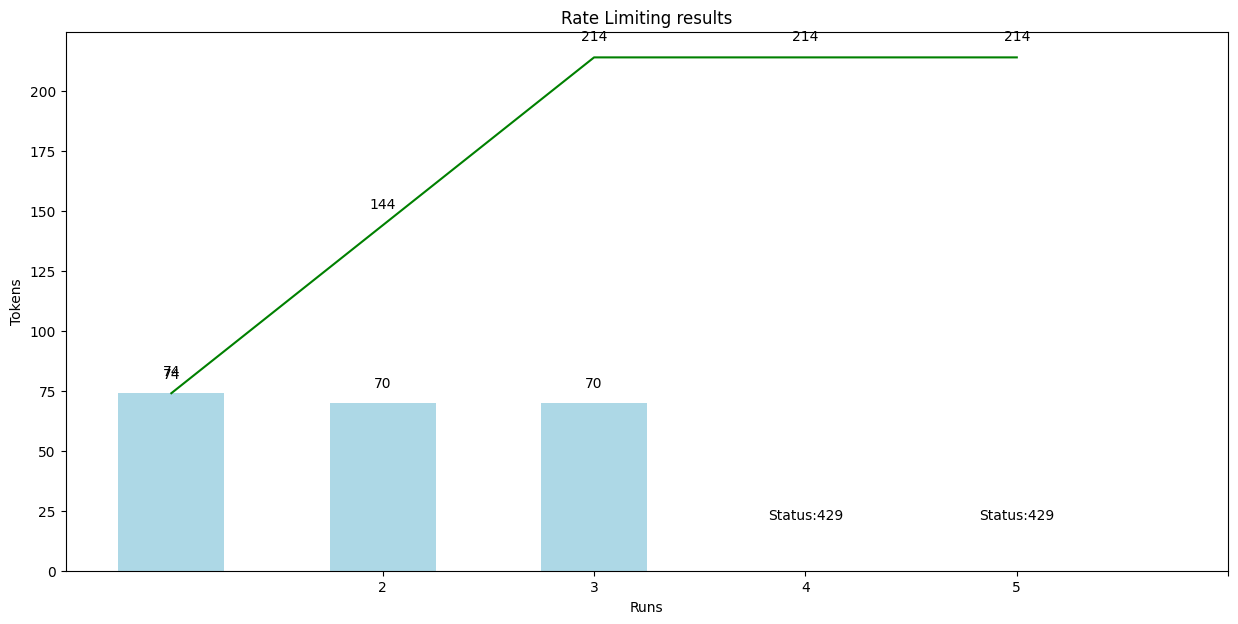

In [7]:
# plot the results
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [15, 7]
df = pd.DataFrame(api_runs, columns=['Tokens', 'Status Code'])
df['Run'] = range(1, len(df) + 1)
colors = ['red' if str(code).startswith('5') else 'yellow' if str(code).startswith('4') else 'lightblue' for code in df['Status Code']]
ax = df.plot(kind='bar', x='Run', y='Tokens', color=colors, legend=False)
plt.title('Rate Limiting results')
plt.xlabel('Runs')
plt.ylabel('Tokens')
plt.xticks(df['Run'], rotation=0)
for i, val in enumerate(df['Status Code']):
    ax.text(i, 20, '' if int(val) == 200 else 'Status:429', ha='center', va='bottom')
for i, val in enumerate(df['Tokens']):
    ax.text(i, df['Tokens'][i] + 5, '' if int(val) == 0 else int(val), ha='center', va='bottom')
accumulated_tokens = df['Tokens'].cumsum()
ax.plot(df['Run']-1, accumulated_tokens, color='green', label='Accumulated Tokens')
for i, val in enumerate(accumulated_tokens):
    ax.text(i, val + 6, int(val), ha='center', va='bottom', label='Accumulated Tokens')
plt.show()